In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import fftpack
import datetime
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')

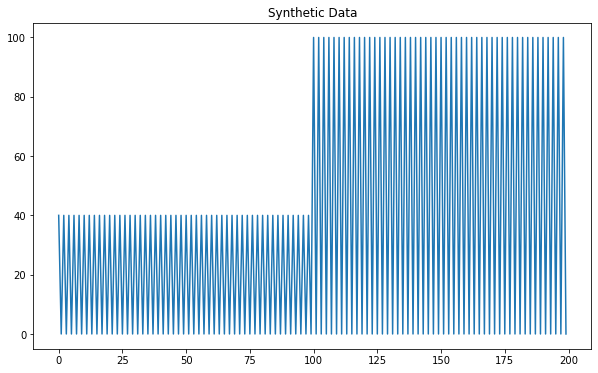

In [2]:
x = np.arange(0, 200)
y1 = np.zeros(100)
y2 = np.zeros(100)
for i in range (0, 100):
    if i%2 == 0:
        y1[i] = 40
    else:
        y1[i] = 0
#for i in range (100, 200):
#    if (i%2 == 1):
#        y2[i-100] = 50
#    elif (i%4 == 0):
#        y2[i-100] = 0
#    else:
#        y2[i-100] = 100
for i in range (0, 100):
    if i%2 == 0:
        y2[i] = 100
    else:
        y2[i] = 0
y = np.concatenate((y1, y2), axis=None)
plt.figure(figsize=(10,6))
plt.plot(x, y)
plt.title("Synthetic Data")
plt.show()

In [3]:
signal_1 = pd.DataFrame(zip(x,y),columns=['Time','Value'])

In [4]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    freq_ampli = pd.DataFrame(zip(np.abs(f[:N//2+1]),2.0/N * np.abs(yf[:N//2+1])),columns=['Freq','Ampli'])
    return freq_ampli 
freq_ampli1 = freq(signal_1)

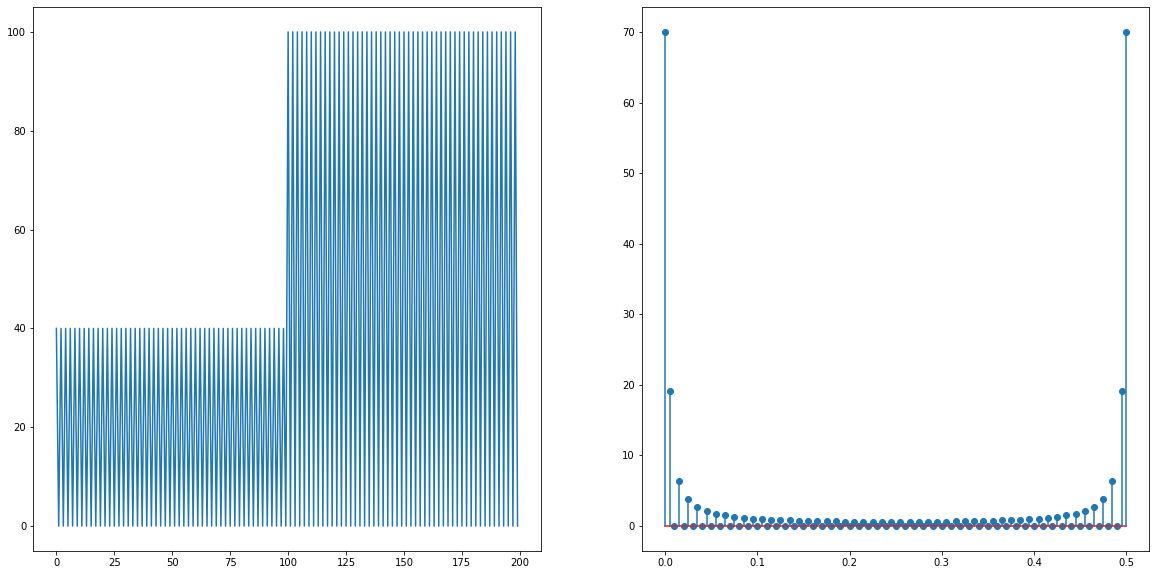

In [5]:
fig, axs = plt.subplots(1, 2,figsize=(20,10))
axs[0].plot(signal_1['Time'], signal_1['Value'])
axs[1].stem(freq_ampli1['Freq'], freq_ampli1['Ampli'])
plt.show()

In [6]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 7)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm

In [7]:
best_gmm00 = GMM_fit(signal_1)
best_gmm01 = GMM_fit(np.array(signal_1['Value']).reshape(-1,1))
best_gmm02 = GMM_fit(freq_ampli1)#.iloc[1:])

In [8]:
print(best_gmm00)
print(best_gmm00.weights_)
print(best_gmm00.means_)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
[0.2569345 0.25      0.25      0.2430655]
[[ 52.78301446   0.        ]
 [149.         100.        ]
 [ 49.          40.        ]
 [149.91112707   0.        ]]


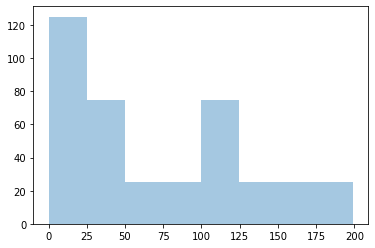

In [9]:
sns.distplot(signal_1,kde=False)
z1,_ = best_gmm00.sample(200)
#sns.distplot(z1,kde=False)

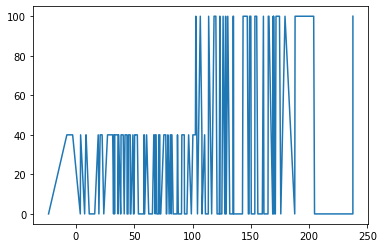

In [10]:
sns.lineplot(z1[:,0],z1[:,1])

In [11]:
print(best_gmm01)
print(best_gmm01.weights_)
print(best_gmm01.means_)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
[0.25 0.5  0.25]
[[100.]
 [  0.]
 [ 40.]]


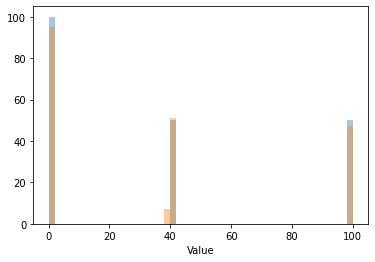

In [12]:
sns.distplot(signal_1['Value'],kde=False,bins=50)
z1,_ = best_gmm01.sample(200)
sns.distplot(z1,kde=False,bins=50)

In [13]:
print(best_gmm02)
print()
print(best_gmm02.weights_)
print()
print(best_gmm02.means_)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

[0.48513767 0.01980198 0.01980198 0.10849222 0.20139517 0.16537098]

[[2.50000000e-01 3.67686666e-16]
 [2.50000000e-01 7.00000000e+01]
 [2.50000000e-01 1.91017351e+01]
 [2.50000000e-01 3.16736521e+00]
 [2.50000000e-01 9.88791662e-01]
 [2.50000000e-01 6.32652966e-01]]


In [14]:
best_gmm02.score(freq_ampli1)

2.631441805356411

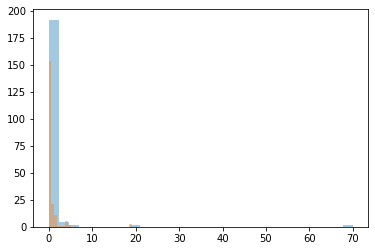

In [15]:
sns.distplot(freq_ampli1,kde=False,bins=30)
z1,_ = best_gmm02.sample(100)
sns.distplot(z1,kde=False,bins=30)

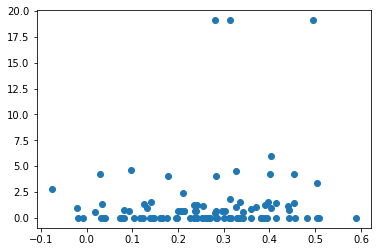

In [16]:
plt.scatter(z1[:,0],z1[:,1])

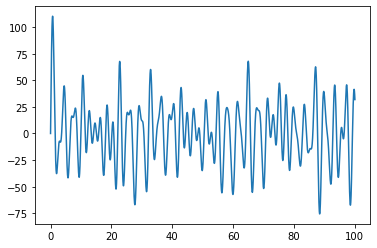

In [17]:
Fs = 100
t = np.arange(0,100,1/Fs)
y = 0
for [i,j] in z1:
    y += j*np.sin(2 * np.pi * (i) * t)
plt.plot(t,y)